In [43]:
import os
import numpy as np
import pandas as pd

import pymatgen as pg


In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [45]:

def local_min(df):

    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()

    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] > 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df
    local_mins = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)

    return local_mins

def local_max(df):
    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()
    
    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] < 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df

    local_max = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)
    return local_max

In [46]:
def finding_diff(df):
    abs_max = df['Edis'].iloc[-1]
    max_val = max(local_max(df)['Edis'])
    min_val = min(local_min(df)['Edis'])
    min_val_idx = local_min(df)[local_min(df)['Edis'] == min_val].index[0]
    min_length = local_min(df).loc[min_val_idx, 'cell_length']
    
    max_val_idx = local_max(df)[local_max(df)['Edis'] == max_val].index[0]
    
    # equation of line between two points (x1, y1) and (x2, y2)
    x1 = local_max(df).loc[max_val_idx, 'cell_length'] 
    x2 = df['cell_length'].iloc[-1]

    y1 = max_val
    y2 = abs_max
    # print(min_length)
    
    # Finding the maximum slope
    max_slope = float('-inf')
    best_x2 = x2
    best_y2 = y2
    
    # Get the dataframe points after x1
    points_after_x1 = df[df['cell_length'] > x1][['cell_length', 'Edis']]
    
    # Iterate through all points after x1
    for idx, row in points_after_x1.iterrows():
        temp_x2 = row['cell_length']
        temp_y2 = row['Edis']
        temp_slope = (y1 - temp_y2) / (x1 - temp_x2)
        
        if temp_slope > max_slope:
            max_slope = temp_slope
            best_x2 = temp_x2
            best_y2 = temp_y2
    
    x2 = best_x2
    y2 = best_y2
    slope = max_slope
    intercept = y2 - slope * x2

    if y2 < y1:
        slope = 0
        intercept = y1

    #value of y when x = min_length
    y_at_min_length = slope * min_length + intercept

    diff = abs(min_val - y_at_min_length)
    return diff


In [47]:
from pymatgen.core import Structure

In [48]:
#list all folders inside li_d3s
li_d3s = os.listdir("d3_calcs")

results = []

df = pd.DataFrame()
cnt=0
for items in li_d3s:
    cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')
    df = pd.read_csv(file)
    print(f"Reading {file}")
    # exract materials id from file name

    material_id = os.path.basename(file).split('.')[0].split('_')[1]
    print(f"Material ID: mp-{material_id}")
    struct = Structure.from_file(struct_file)
    sites = struct.num_sites
    
    # print(struct.composition['Li'])
    li_sites = struct.composition['Mg']
    counter_ion_sites = struct.composition[struct.composition.elements[1]]
    diff_energy = finding_diff(df)
    print(f'Composition {struct.composition}')
    print(f'diff per toal sites {diff_energy/sites}')
    print(f'diff per cation sites {diff_energy/li_sites}')
    print('-----------------------------------')

    result = {
        "Symbol": struct.composition.elements[0] if struct.composition.elements[0].symbol != 'Mg' else struct.composition.elements[1],
        "Structure": struct.composition,
        "Total Sites": sites,
        "Cation Sites": li_sites,
        "Counter Ion Sites": counter_ion_sites,
        "Diff Energy": diff_energy,
        "Diff per Total Sites": diff_energy/sites,
        "Diff per Cation Sites": diff_energy/li_sites,
        "Diff per Counter Ion Sites": diff_energy/counter_ion_sites,
        "Volume": struct.volume,
        "mid": material_id,
        "Composition": str(struct.composition)
    }

    results.append(result)
print(f'total structure analysed = {cnt}')
    

Reading d3_calcs/Mg3Ag_864952/Mg3Ag_864952.csv
Material ID: mp-864952
Composition Mg6 Ag2
diff per toal sites 0.004698189421087431
diff per cation sites 0.006264252561449908
-----------------------------------
Reading d3_calcs/TmMg3_1187610/TmMg3_1187610.csv
Material ID: mp-1187610
Composition Tm1 Mg3
diff per toal sites 0.013219366302509514
diff per cation sites 0.017625821736679353
-----------------------------------
Reading d3_calcs/MgSe_10760/MgSe_10760.csv
Material ID: mp-10760
Composition Mg1 Se1
diff per toal sites 0.0023657772056896505
diff per cation sites 0.004731554411379301
-----------------------------------
Reading d3_calcs/Yb2Mg_3217237/Yb2Mg_3217237.csv
Material ID: mp-3217237
Composition Yb4 Mg2
diff per toal sites 0.020697145292241592
diff per cation sites 0.062091435876724776
-----------------------------------
Reading d3_calcs/MgAg2_1185840/MgAg2_1185840.csv
Material ID: mp-1185840
Composition Mg2 Ag4
diff per toal sites 0.004725449754595737
diff per cation sites 0.

### for individual elements

In [49]:
results_df = pd.DataFrame(results)
results_df.to_csv("analysis_results.csv", index=False)

print(f"Total structures analysed = {cnt}")
# print("Results saved to analysis_results.csv")

results_df['Diff per Total Sites'].max()*1000

Total structures analysed = 529


27.89047583644721

### Thougest part is to make the Feature functions data 


In [50]:
props = pd.read_csv('../mixed_comps/PubChemElements_all.csv')
polarisability = pd.read_csv('../elements_polarizability.csv')

props = props[['Symbol', 'AtomicMass','AtomicRadius','Electronegativity','IonizationEnergy','ElectronAffinity']]

In [51]:
all_props = []
cnt = 0
for items in li_d3s:
    # cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')


    struct = Structure.from_file(struct_file)
    sites = struct.num_sites

    vol_site = struct.volume/sites
    # print(density)

    # print(struct.composition.elements[1])

    elem = struct.composition.elements[0] if(struct.composition.elements[1].symbol == 'Mg')  else struct.composition.elements[1]

    print(elem)
    # print(elem.symbol == 'Ge')

    matched_row = props[props['Symbol'] == elem.symbol]
    elem_polarizability = polarisability[polarisability['Symbol'] == elem.symbol]

    space_group = struct.get_space_group_info()


    
    print(struct.composition.reduced_formula)
    # DiffPerLi = results_df[results_df['Symbol'] == elem.symbol]
    # matched_row.add('Polarizability', elem_polarizability['Polarizability'].values[0])
    matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
    matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
    matched_row['results_per_cation'] = results_df['Diff per Cation Sites'][cnt]*1000
    # matched_row['TotalSites'] = results_df['Total Sites'][cnt]
    matched_row['CationSites'] = results_df['Cation Sites'][cnt]/sites
    matched_row['CounterIonSites'] = results_df['Counter Ion Sites'][cnt]/sites
    matched_row['results_per_counter_ion'] = results_df['Diff per Counter Ion Sites'][cnt]
    # matched_row['Diff per Li Sites'] = DiffPerLi['Diff per Li Sites'].values[0]
    matched_row['res_per_volm_per_site'] = results_df['Diff per Total Sites'][cnt]/vol_site
    matched_row['Result']=  results_df['Diff per Total Sites'][cnt]/vol_site*1000
    matched_row['SpaceGroup'] = space_group[0]
    matched_row['SpaceGroupNumber'] = space_group[1]
    matched_row['Total Sites'] = sites
    matched_row['Volume'] = results_df['Volume'][cnt]
    matched_row['mid'] = results_df['mid'][cnt]
    matched_row["Reduced Formula"] = struct.composition.reduced_formula
    all_props.append(matched_row)

    cnt+=1

all_props_df = pd.concat(all_props, ignore_index=True)
    

Ag
Mg3Ag
Tm
TmMg3
Se
MgSe
Yb
Yb2Mg
Ag
MgAg2
Ce
CeMg12
I
Mg149I
Lu
LuMg3
Li
LiMg
Tl
Mg5Tl2
Te
MgTe
Ca
CaMg
Pb
Mg3Pb
Pd
MgPd3
Ag
MgAg3
Tm
TmMg
Sr
Sr2Mg
Sn
Mg9Sn5
Ag
MgAg2
Au
MgAu3
Ca
CaMg2
Li
LiMg3
Pt
Mg3Pt
C
Mg3C
O
MgO
Hg
Mg3Hg
Ca
CaMg
Pr
PrMg3
F
MgF2
Sr
Sr2Mg17
Ag
Mg2Ag
Li
LiMg
Tl
Mg149Tl
Y
YMg2
Rh
MgRh
B
MgB4
Fe
Mg149Fe
Rh
Mg149Rh
Eu
EuMg
Pb
MgPb
Pt
MgPt7
Tm
TmMg3
Ga
MgGa
Sc
MgSc
Eu
EuMg
Ac
Ac2Mg
Cu
Mg2Cu
Ru
Mg3Ru2
F
MgF2
Ca
CaMg
O
MgO
Li
Li2Mg
Sn
Mg2Sn


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Ca
CaMg
Nd
Nd2Mg
Au
Mg3Au
Zn
Mg4Zn7
Pd
Mg3Pd5
Zn
MgZn2
P
MgP4
Li
LiMg
Ag
MgAg2
Tm
TmMg2
S
MgS
Li
Li2Mg
Li
LiMg
Yb
Yb2Mg
Tm
TmMg2
Li
LiMg2
Pd
Mg3Pd
Hg
Mg5Hg
H
MgH2
Se
MgSe
P
Mg3P2
Ga
MgGa
Er
ErMg3
Tm
Tm5Mg24
Cd
Mg2Cd
Ir
Mg3Ir
Ca
Ca2Mg
Sm
Sm2Mg
Ce
CeMg5
O
MgO
Li
LiMg
Bi
Mg149Bi
Ga
MgGa5
Zr
Mg149Zr
Ta
Mg149Ta
Tl
Mg2Tl
Cu
Mg2Cu
Ac
AcMg5
F
MgF2
O
MgO
Hg
Mg3Hg
Cl
MgCl2
Li
LiMg2
Pm
PmMg
Al
Mg16Al13
Dy
DyMg149
Ca
CaMg
Sc
MgSc
Tb
Tb3Mg
Yb
YbMg
Zn
Mg2Zn11
Cl
MgCl2
Te
MgTe
Ni
Mg2Ni
Cl
Mg149Cl
Dy
DyMg
Hf
Hf3Mg
Au
Mg13Au41
Ac
AcMg
Lu
LuMg
Tb
TbMg149
Eu
EuMg2
Au
MgAu2
Li
LiMg3
C
Mg2C3
Gd
GdMg3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Li
LiMg5
H
MgH2
Hg
MgHg2
Ag
Mg2Ag
S
MgS2
B
MgB2
La
LaMg3
Au
MgAu5
Hg
MgHg2
Y
YMg2
Li
LiMg
Li
Li3Mg
Ti
MgTi3
Tc
Mg149Tc
Dy
DyMg3
Y
YMg3
Ca
Ca5Mg
O
MgO
Al
Mg23Al30
Ac
AcMg3
La
La4Mg
Li
LiMg3
Rb
RbMg149
Nb
Mg149Nb
Ag
MgAg3
O
MgO
Dy
DyMg3
Bi
Mg2Bi
Ga
Mg149Ga
Zn
Mg4Zn7
B
MgB7
Pd
MgPd3
Sb
Mg3Sb2
Pt
Mg149Pt
Sm
SmMg2
Cd
Mg3Cd
Sc
Mg2Sc
Pr
PrMg149
Sr
Sr9Mg38
Pd
Mg2Pd
Th
ThMg149
Tb
TbMg2
Cd
MgCd
Li
Li2Mg
Pt
Mg3Pt


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Pb
MgPb3
Hg
Mg149Hg
Br
Mg149Br
Y
YMg2
Cd
Mg2Cd
Au
Mg3Au13
Lu
LuMg3
Cd
Mg2Cd
Li
LiMg5
Cr
Mg149Cr
C
Mg3C
Li
Li2Mg
Au
MgAu2
Ca
Ca2Mg
Er
Er5Mg24
Ho
HoMg2
Sm
Sm5Mg41
C
Mg7C
Ga
MgGa3
F
MgF2
Li
Li3Mg
Ru
Mg149Ru
Ge
Mg2Ge
Li
Li2Mg
Se
MgSe
Ca
Ca2Mg
Ce
CeMg
Rh
Mg3Rh
Mn
Mg149Mn
Ca
CaMg2
Br
MgBr2
C
MgC
Sc
Mg149Sc
Li
Li3Mg
Sr
SrMg2
Li
LiMg
Li
Li2Mg
Te
MgTe2
Rh
MgRh3
Dy
Dy5Mg24
Cd
MgCd
Dy
DyMg2
Li
Li3Mg5
Pt
MgPt3
Er
ErMg149
P
Mg149P
Zn
Mg4Zn7
Li
Li5Mg
Ba
Ba6Mg23
Dy
DyMg2
Pt
MgPt
Pr
Pr5Mg41
O
MgO
Pm
Pm2Mg
Cd
MgCd3
Au
Mg2Au
H
MgH2
As
Mg3As2
Ni
MgNi2
Rh
Mg2Rh
Dy
DyMg2
Au
MgAu3
Ga
MgGa
Bi
MgBi
Li
LiMg
Li
LiMg7
S


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

MgS
Au
MgAu3
Gd
GdMg
In
MgIn2


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Ti
Mg149Ti
Gd
GdMg2
O
MgO
Sm
SmMg
Li
LiMg
Nd
NdMg3
Pd
Mg2Pd
V
Mg149V
Ag
MgAg
Ac
AcMg3
Er
Er2Mg
Ag
MgAg5
Ce
CeMg
Pd
MgPd5
Cl
MgCl2
Li
Li2Mg
Sc
Mg3Sc
In
Mg3In
Cl
MgCl6
Ir
MgIr2
La
LaMg2
Ca
CaMg
Ac
AcMg149
Te
MgTe
O
MgO
Lu
LuMg149
Li
LiMg
Ho
Ho5Mg24
Dy
Dy2Mg
Ga
MgGa
Li
LiMg2
Y
Y4Mg25
Pd
MgPd3
Se
Mg149Se
Pb
Mg2Pb
Li
Li2Mg
In
Mg5In2
Ba
BaMg149
Nd
NdMg149
Ca
Ca2Mg
Si
Mg149Si
Li
LiMg2
Li
Li2Mg
Ga
MgGa2
Cd
MgCd2
Pt
Mg2Pt
Ag
Mg5Ag
Ce
CeMg
Pr
Pr2Mg
Cl
MgCl2
Sn
MgSn
Ca
CaMg2
Ga
Mg5Ga2
Yb
YbMg2
Sr
Sr2Mg
Zn
MgZn2
Au
MgAu3
Cd
MgCd3
Cd
MgCd
Au
MgAu3
Li
Li5Mg
Ho
HoMg3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Ag
MgAg3
Cu
Mg2Cu
Y
Y19Mg97
Hg
MgHg2
Hg
Mg2Hg
Cd
MgCd2
As
Mg3As2
Pd
MgPd3
F
MgF2
Li
Li5Mg
Ho
HoMg2
Pr
PrMg2
Y
YMg149
O
MgO
Sn
Mg3Sn
Cd
Mg3Cd
Sn
Mg149Sn
Te
Mg149Te
Y
YMg
Hg
MgHg
Hg
Mg3Hg
Li
LiMg3
Ho
HoMg149
Ag
MgAg2
Y
YMg3
Pd
Mg5Pd2
Pd
MgPd2
In
MgIn2
Sb
Mg149Sb
Pm
PmMg2
Ag
MgAg2
O
MgO
Li
LiMg2
Ag
Mg149Ag
Ce
CeMg
Cl
MgCl2
Li
Li2Mg
La
La2Mg17
O
MgO2
O
MgO2
Ir
Mg3Ir
Au
Mg3Au
Pr
PrMg12
Li
Li3Mg
Eu
EuMg
In
Mg3In
Ir
MgIr
Tm
Tm2Mg
Li
LiMg2
Ag
Mg2Ag
Ag
Mg26Ag7
Er
ErMg2
Nd
NdMg
Br
MgBr6
Tm
TmMg3
Ca
CaMg
Ir
Mg29Ir4
Sm
SmMg3
O
MgO
O
MgO
In
Mg2In
Ac
AcMg5
In
Mg3In
Cd
Mg5Cd


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Ce
Ce5Mg41
In
MgIn
Ba
Ba2Mg17
Ca
Ca2Mg
Au
MgAu
Ir
Mg44Ir7
Hg
Mg3Hg
Y
Y5Mg24
O
MgO
Cu
MgCu2
Ag
Mg54Ag17
Hg
MgHg2
S
MgS
Tl
MgTl
P
Mg3P2
In
Mg149In
Hg
Mg5Hg3
Yb
YbMg3
Tm
TmMg2
Nd
NdMg2
Li
LiMg5
Pm
Pm2Mg
Cd
Mg2Cd
Cl
MgCl2
Ga
Mg2Ga
La
La5Mg41
Eu
EuMg2
Li
LiMg
Pm
Pm2Mg
S
MgS2
Pm
PmMg149
Al
Mg17Al12
Tb
Tb2Mg
Be
Mg149Be
Ba
BaMg2
Ho
HoMg
Au
MgAu5
Sm
Sm2Mg
O
MgO
La
LaMg12
Au
MgAu2
Dy
Dy3Mg
Pb
Mg3Pb
Sc
Mg2Sc
Sr
SrMg2
Ni
Mg149Ni
Li
LiMg3
Ce
CeMg2
Ga
Mg2Ga5


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Sn
Mg9Sn5
Zn
Mg21Zn25
Au
MgAu2
O
MgO
Cd
MgCd2
N
Mg3N2
Pm
PmMg3
Nd
Nd5Mg41
O
MgO
Ho
Ho2Mg
Zn
Mg149Zn
Zn
Mg3Zn
Al
MgAl2
Li
Li3Mg
Li
Li5Mg
Au
Mg3Au
Ho
HoMg3
Ca
CaMg2
As
MgAs4
Mo
Mg149Mo
Ag
Mg2Ag
Hf
HfMg149
Yb
YbMg3
Cd
Mg3Cd
La
LaMg3
La
LaMg
Sr
Sr6Mg23
Pd
Mg149Pd
Li
LiMg3
Ni
MgNi2
S
Mg149S
Ce
CeMg3
Ba
BaMg
Bi
Mg3Bi2
Bi
MgBi
Sb
Mg3Sb2
Sm
SmMg149
Li
Li4Mg
Lu
LuMg3
Y
Y2Mg
I
MgI2
Li
Li2Mg
Re
Mg149Re
Tl
Mg3Tl
Y
YMg
Tm
TmMg3
Cd
Mg3Cd
Pd
MgPd
O
MgO
C
Mg15C
Al
Mg16Al13
In
Mg3In
Er
ErMg
Er
Er3Mg
Li
LiMg5
Nd
NdMg12
Se
MgSe2
Cd
MgCd
Au
Mg149Au
H
MgH2
Sc
MgSc2
H
MgH2
Li
LiMg


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

O
MgO2
Y
Y2Mg
Li
Li2Mg
Rh
Mg5Rh2
Li
LiMg
Tb
Tb5Mg24
Pd
Mg3Pd
O
MgO
O
MgO
Te
MgTe
Al
Mg149Al
Ni
Mg2Ni
Er
ErMg2
Sr
SrMg2
Sm
Sm2Mg
Li
LiMg
Ce
CeMg
Li
Li3Mg
Tm
Tm3Mg
Yb
Yb5Mg
Nd
Nd2Mg
Sc
MgSc
Er
ErMg3
Pb
MgPb
Li
Li5Mg
La
LaMg2
Eu
EuMg3
C
MgC2
H
MgH2
Pb
Mg149Pb
Tb
TbMg
Ga
MgGa2
Bi
MgBi
Li
LiMg
Tb
TbMg3
Ir
Mg13Ir3
La
LaMg
O
MgO
Bi
MgBi
In
MgIn3
Pr
PrMg
Ca
CaMg5
Ir
Mg2Ir3
Rh
Mg44Rh7
Tb
TbMg3
Ho
HoMg2
Li
LiMg149
Si
Mg2Si


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

Eu
EuMg149
O
MgO
Sr
SrMg5
Er
Er2Mg
Ag
MgAg5
Bi
Mg3Bi2
Pd
MgPd5
Ca
CaMg
Sc
Mg3Sc


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_69945/1839498199.py:41: SettingWith

In [52]:
all_props_df


,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_cation,CationSites,CounterIonSites,results_per_counter_ion,res_per_volm_per_site,Result,SpaceGroup,SpaceGroupNumber,Total Sites,Volume,mid,Reduced Formula
0,Ag,107.86800,172.0,1.93,7.576,1.302,55.00,4.698189,6.264253,0.750000,0.250000,0.018793,0.000238,0.237948,P6_3/mmc,194,8,157.956630,864952,Mg3Ag
1,Tm,168.93422,227.0,1.25,6.184,NaN,144.00,13.219366,17.625822,0.750000,0.750000,0.017626,0.000557,0.557184,Fm-3m,225,4,94.901190,1187610,TmMg3
2,Se,78.97000,190.0,2.55,9.752,2.021,28.90,2.365777,4.731554,0.500000,0.500000,0.004732,0.000116,0.115800,Fm-3m,225,2,40.859567,10760,MgSe
3,Yb,173.05000,242.0,NaN,6.254,NaN,139.00,20.697145,62.091436,0.333333,0.333333,0.062091,0.000753,0.752764,I4/mmm,139,6,164.969234,3217237,Yb2Mg
4,Ag,107.86800,172.0,1.93,7.576,1.302,55.00,4.725450,14.176349,0.333333,0.666667,0.007088,0.000258,0.257545,C2/m,12,6,110.088475,1185840,MgAg2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Ag,107.86800,172.0,1.93,7.576,1.302,55.00,4.878565,29.271392,0.166667,0.833333,0.005854,0.000280,0.279781,R32,155,6,104.622491,1185839,MgAg5
525,Bi,208.98040,207.0,2.02,7.289,0.946,53.00,4.070452,6.784087,0.600000,0.400000,0.010176,0.000145,0.145109,P-3m1,164,5,140.254610,569018,Mg3Bi2
526,Pd,106.42000,202.0,2.20,8.337,0.557,26.14,17.470966,104.825797,0.166667,0.833333,0.020965,0.001152,1.151788,R32,155,6,91.011368,976976,MgPd5
527,Ca,40.08000,231.0,1.00,6.113,NaN,160.80,11.213859,22.427719,0.500000,0.500000,0.022428,0.000358,0.357960,Amm2,38,12,375.925217,1038953,CaMg


In [53]:
all_props_df.to_csv('all_props_new.csv', index=False)

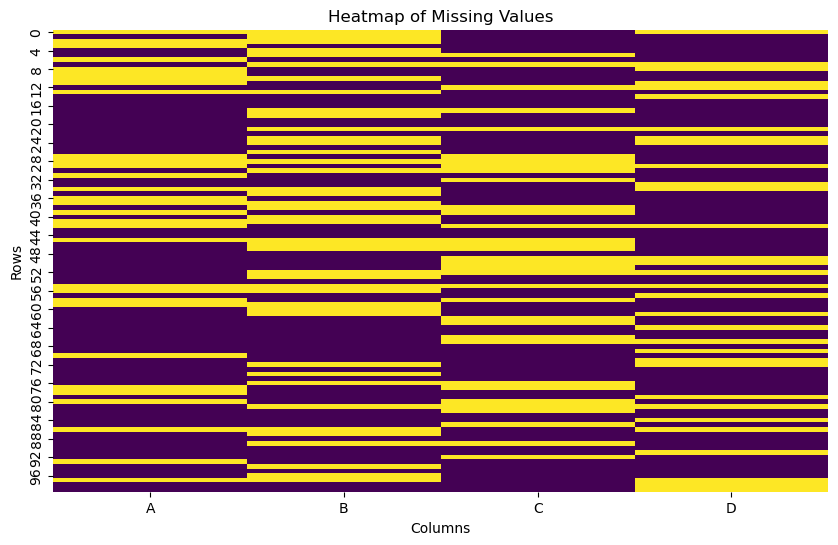

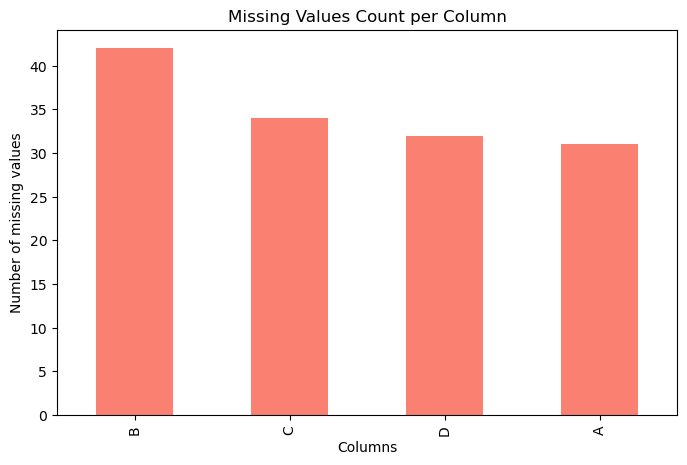

In [54]:
# show me some graphs to analyze NaN values

import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame with NaN values (replace this with your actual DataFrame)
# For demonstration, we're creating a DataFrame with some random missing values.
np.random.seed(42)
data = {
    'A': np.random.choice([1, 2, np.nan], size=100),
    'B': np.random.choice([3, 4, np.nan], size=100),
    'C': np.random.choice([5, 6, np.nan], size=100),
    'D': np.random.choice([7, 8, np.nan], size=100)
}
df = pd.DataFrame(data)

# -------------------------------
# Plot 1: Heatmap of Missing Values
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# -------------------------------
# Plot 2: Bar Chart of Missing Values per Column
# -------------------------------
missing_counts = df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
missing_counts.plot(kind="bar", color='salmon')
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.title("Missing Values Count per Column")
plt.show()

In [55]:
all_props_df.fillna(0, inplace=True)


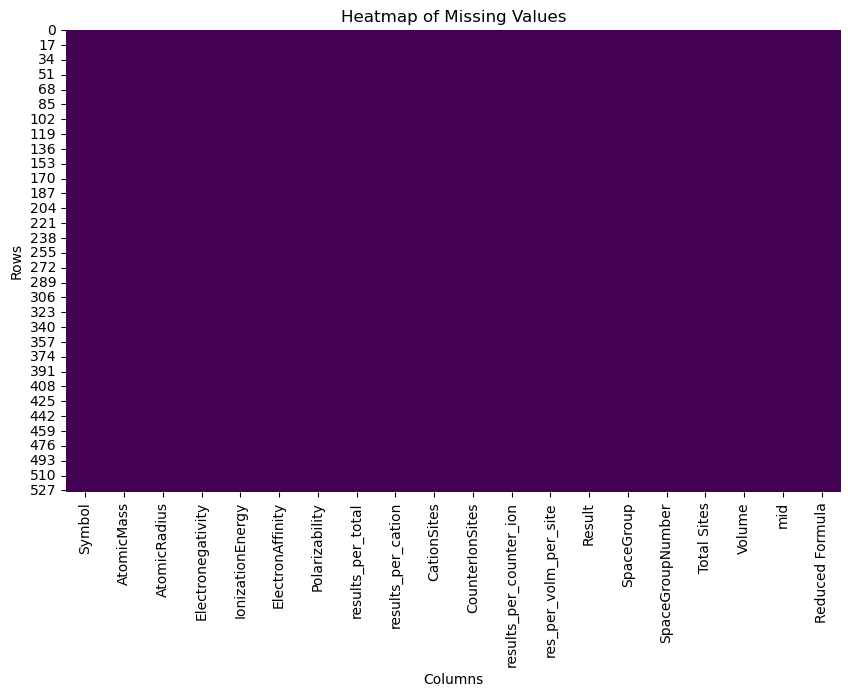

In [56]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_props_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [57]:
# all_props_df.to_csv('all_props_new.csv', index=False)
all_props_df = pd.read_csv('all_props.csv')

all_props_df

FileNotFoundError: [Errno 2] No such file or directory: 'all_props.csv'